<a href="https://colab.research.google.com/github/wdwzyyg/Benchmark-test-for-atom-finding-models/blob/main/Atomfinder_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will walk you through loading the STEM image benchmark dataset
from Foundry and running atom-position finding models. An example of calculating the evaluation metrics as mentioned in the paper is also included. Please refer to 

## Install Foundry and import related libraries. 

In [1]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [ ]:
!pip install foundry_ml 
!pip freeze

# Fetch benchmark dataset from Foundry


The code in the next cell will detect your environment to make sure that only cells that match your environment will run. Running in Google Colab requires a few changes compared to running locally.

In [2]:
try:
  import google.colab
  no_local_server=True
  no_browser=True
  globus=False

  from google.colab import data_table
  data_table.enable_dataframe_formatter()

except: # when not in google colab
  no_local_server=False
  no_browser=False
  globus=True

Datasets in Foundry can be accessed by their permanent digital object identifiers (DOIs). The cell below will load the STEM benchmark dataset from Foundry using its DOI. If you have not authenicated to Globus, which provides authentication and file transfer infrastructure for Foundry, you will prompted to do so. This use of Globus is free and supports institutional user credentials for many labs and universities around the world. See <b>https://www.globus.org/</b> for more information about the Globus service and obtaining access.

Once the data loads, you should see some summary metadata about the dataset.

In [21]:
from foundry import Foundry
f = Foundry(index="mdf", no_local_server=no_local_server, no_browser=no_browser)

doi = '10.18126/e73h-3w6n'
dataset = f.load(doi,download=True, globus=globus)
dataset

Foundry(dc={'creators': [{'affiliations': ['University of Wisconsin - Madison'], 'creatorName': 'Wei, Jingrui', 'familyName': 'Wei', 'givenName': 'Jingrui'}, {'affiliations': ['University of Chicago', 'Argonne National Laboratory'], 'creatorName': 'Blaiszik, Ben', 'familyName': 'Blaiszik', 'givenName': 'Ben'}, {'affiliations': ['University of Wisconsin - Madison'], 'creatorName': 'Morgan, Dane', 'familyName': 'Morgan', 'givenName': 'Dane'}, {'affiliations': ['University of Wisconsin - Madison'], 'creatorName': 'Voyles, Paul', 'familyName': 'Voyles', 'givenName': 'Paul'}], 'dates': [{'date': '2021-07-15', 'dateType': 'Accepted'}], 'identifier': {'identifier': '10.18126/e73h-3w6n', 'identifierType': 'DOI'}, 'publicationYear': 2021, 'publisher': 'Materials Data Facility', 'resourceType': {'resourceType': 'Dataset', 'resourceTypeGeneral': 'Dataset'}, 'subjects': [{'subject': 'machine learning'}, {'subject': 'foundry'}, {'subject': 'atom finding'}, {'subject': 'materials'}, {'subject': 'STEM'}], 'titles': [{'title': 'Benchmark Dataset for Locating Atoms in STEM images'}]}, mdf={'ingest_date': '2021-07-15T14:24:40.739344Z', 'organizations': ['Foundry'], 'resource_type': 'dataset', 'scroll_id': 0, 'source_id': 'foundry_wei_atom_locating_benchmark_v1.1', 'source_name': 'foundry_wei_atom_locating_benchmark', 'version': 1}, dataset=FoundryDataset(keys=[FoundryKey(key=['imgs'], type='input', filter='', units='', description='input, unlabeled images', classes=None), FoundryKey(key=['raw'], type='input', filter='', units='', description='raw, unlabeled images', classes=None), FoundryKey(key=['metadata'], type='input', filter='', units='', description='tabular information describing the experimental conditions and materials for each image', classes=None), FoundryKey(key=['coords'], type='target', filter='', units='', description='(x,y) coordinates for labeled atoms for each image', classes=None)], splits=[FoundrySplit(type='train', path='wei_atom.h5', label='train')], data_type=<FoundryDatasetType.hdf5: 'hdf5'>, short_name='wei_atom_locating', dataframe=None, task_type=['supervised'], domain=['materials science'], n_items=299), config=FoundryConfig(dataframe_file='foundry_dataframe.json', data_file='foundry.hdf5', metadata_file='foundry_metadata.json', destination_endpoint=None, local=False, metadata_key='foundry', organization='foundry', local_cache_dir='./data'), dlhub_client=<dlhub_sdk.client.DLHubClient object at 0x7f2be5c95f90>, forge_client=<mdf_forge.forge.Forge object at 0x7f2be5cb80d0>, connect_client=<mdf_connect_client.mdfcc.MDFConnectClient object at 0x7f2be5c95290>, xtract_tokens={'auth_token': 'Agy8E4dmeaPYkgkmbKm5njVQ59YXbNWojYe7nDPpMznO0pNGYBFVCBjKwxDXDW0KONxKyaorGoboG7fWn2X9MhWe1p', 'transfer_token': 'Agdaz4bPXJJ0vMv3GNnvjEMDyJ1KvB6pQvPjjGzebg95EBzlDlCXCGDa87JDl5zrGnPjoaBxyoKl6mUMo3k7rC9lWo', 'funcx_token': 'Agq95o5kl0nwde653dEQvPxdv1qM25JOdj8P21pJ20DYyxBxvxCqCwGVm10po1BbrnpMP1Qv3lP8EWS5WklmzSrPJ5'}, index='mdf')

In [22]:
# load the HDF5 image data into a local object
res = dataset.load_data()

# using the 'train' split, 'input' or 'target' type, and Foundry Keys specified by the dataset publisher
# Grab the atom images, metadata, and ground truth coorinates
imgs = res['train']['input']['imgs']
desc = res['train']['input']['metadata']
coords = res['train']['target']['coords']

# Run a model through Foundry to find atomic column positions in a image. 

```
>>> from foundry import Foundry
>>> f = Foundry(index="mdf", no_local_server=no_local_server, no_browser=no_browser)
>>> f.run(model_name, inputs)
```



The input of the models is a dictionary of input STEM image arrays, the model weights to be loaded, and an image resize factor. You can also past a list of dictionaries to process multiple images at one call of the model. 

e.g.  dictin = {'image': im, 'modelweights': 'cubic', 'change_size': 0.5}



**modelweights:** 


*   The available sets of model weights of Lin model are **'gaussianMask+'** and **'superresolution'** (the two with best performance for the atom finding task within 14 available model weights from original publisher - see the paper for details). 

*   The available sets of model weights of Ziatdinov model are **'cubic'** and **'hexagonal'** targeting images of different crystal lattices.





**change_size:** 

*   Set to 1 to keep the input image the same size.
*   Set to greater than 1 for upsampling and smaller than 1 to downsampling the input image. 
*   Try downsampling if seen many false positives in the background, and try upsampling if seen lots of missed atom columns. 

The cell below will run one of the model on images within the benchmark dataset.




In [24]:
# You can specify the model by their source name or the DOI assigned to them. 
# Below are the two models primarily evaluated in the paper

ziatdinov_model = 'jwei74_wisc/Ziatdinov_AtomNet'
Lin_model = 'jwei74_wisc/Lin_AtomSegNet'

In [25]:
index = 25 # the index number of the image you want to load from the whole dataset (0-298)

key = list(imgs.keys())[index]
im = np.asarray(imgs[key])

# # For Ziatdinov's model
# dictin = {
#   'image': im,
#   'modelweights':'cubic',
#   'change_size': 0.5,
#   }

# For Lin's model
dictin = {
  'image': im,
  'modelweights':'gaussianMask+',
  'change_size': 1,
  }

#predictpos_x, predictpos_y = f.run(ziatdinov_model, dictin)[0]
predictpos_x, predictpos_y = f.run(Lin_model, dictin)[0]

Next we visulize the results. Blue circles indicate ground truth positions, red dots represent the model predictions. The ground truth positions are part of the Foundry data set.

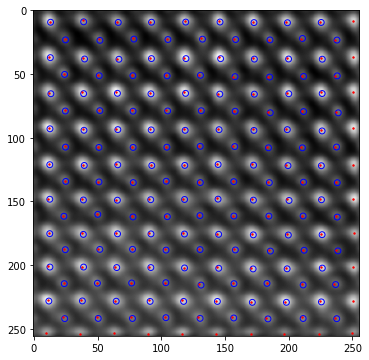

In [26]:
#extract a single image from the set and resize it by the factor used in the analysis
img = Image.fromarray(im, 'L')
img = img.resize((int(im.shape[1]*dictin['change_size']),int(im.shape[0]*dictin['change_size'])), Image.BILINEAR)

#extract the ground truth positions for the same image from the Foundry dataset
truthpos_x,truthpos_y = np.transpose(coords[key])*dictin['change_size']
truthnum = truthpos_y.shape[0]

#display the image with the ground truth positions and the model determined positions as overlays
fig = plt.figure(figsize=(6,6))
plt.imshow(img, cmap = 'gray')
plt.scatter(truthpos_x,truthpos_y,s = 35, facecolors='none', edgecolors = 'b')
plt.scatter(predictpos_x,predictpos_y,s = 2, c = 'red')

plt.show()

Next we will calculate the quality metrics **recall**, **precision**, and **mean position deviation** from the paper for the model identifed positions in this image.

Sometimes atomic columns at the very edges of the input image are not included in the ground truth. To keep this limitation from from disturbing the evaluation scores, we use the functions below to remove predicted atomic column positions that are too close to the edges of the image. Adjusting the edge limit parameter, set here to 0.02, will remove more or fewer columns.

In [27]:
# define function to delete predicted atomic column positions near the edges of the image
def delete_edge_predictions(edges, shape, predictpos_x, predictpos_y):
  '''
  edges:[left, right, top, bottom] as percentage of the whole image size
  '''
  dellistx = []
  for i, coordx in enumerate (predictpos_x):
    dis = abs(coordx-shape[1])/shape[1]
    if dis> (1-edges[0]) or dis < edges[1]: 
      dellistx.append(i)
  dellisty = []
  for i, coordy in enumerate (predictpos_y):
    dis = abs(coordy-shape[0])/shape[0]
    if dis>(1-edges[2])or dis<edges[3]:
      dellisty.append(i)

  dellist = dellistx + dellisty
  dellist = np.unique(np.asarray(dellist))
  try:
    predictpos_x = np.delete(predictpos_x,dellist)
    predictpos_y = np.delete(predictpos_y,dellist)
  except:
    print('You need to re-adjust your edge values for the most accurate measurement\n')
  
  return(predictpos_x, predictpos_y)


# delete predicted atomic column positions near the edges of the image
predictpos_x_refined, predictpos_y_refined = delete_edge_predictions([0.02, 0.03, 0.02, 0.02], im.shape, predictpos_x, predictpos_y)



It's helpful to visualize the results again to check if the edge removal is appropriate.

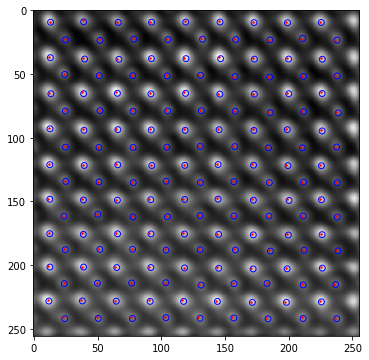

In [28]:
fig = plt.figure(figsize=(6,6))
plt.imshow(img, cmap = 'gray')
plt.scatter(truthpos_x,truthpos_y,s = 35, facecolors='none', edgecolors = 'b')
plt.scatter(predictpos_x_refined,predictpos_y_refined,s = 2, c = 'red')

plt.show()

In [29]:
# define functions to calculate recall, precision, and mean position deviation by comparing model predicted positions to ground truth positions.
def getScores(predictpos_x, predictpos_y, truthpos_x, truthpos_y, truthnum, tolerance):
  truepoints = []
  pos_se = 0
  tp = 0

  for i in range(predictpos_x.size):
    for j in range(truthpos_x.size):
      square_error = (predictpos_x[i] - truthpos_x[j])**2 + (predictpos_y[i] - truthpos_y[j])**2
      if square_error < tolerance:
        truepoints.append((predictpos_y[i],predictpos_x[i]))
        pos_se = pos_se + square_error
        tp = tp + 1

  rmse = math.sqrt(pos_se / tp)
  recall = tp / truthnum
  precision = tp / predictpos_x.size
  print('position deviation = ', rmse, 'px, recall = ', tp, '/', truthnum, ' = ', recall, ', precision = ', tp, '/', predictpos_x.size, ' = ', precision)
  scores = (rmse, recall, precision)
  return scores

In [30]:
# set the max deviation as 0.5 angstrom by recalling the pixel size of the image saved in the Foundry dataset
# You can also just set the tolerance as 5 px2, or as much as you want

tolerance = np.round((0.5/desc['table'][int(key)][1][4]*100)**2, 1) # the final unit is pixel^2
 
rmse, r, p = getScores(predictpos_x_refined, predictpos_y_refined, truthpos_x, truthpos_y, truthnum, tolerance)

position deviation =  1.2107891333262224 px, recall =  162 / 162  =  1.0 , precision =  162 / 162  =  1.0


You can also run the models on your own image by loading your own image into the input dictionary. Here is a code snippet to load an image and evaluate it.

```
>>> From PIL import Image
>>> img = Image.open('path/name.tif')
>>> dictin = {
    'image': np.asarray(img),
    'modelweights':'cubic',
    'change_size': 0.5,
    }
```
